In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
from sqlalchemy import create_engine
from urllib.parse import quote_plus

# ✅ Fetch database credentials from environment variables
db_config = {
    "host": os.getenv("DB_HOST"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "database": "mmt"
}

# ✅ Encode the password (handles special characters like '@', ':', etc.)
encoded_password = quote_plus(db_config["password"])

# ✅ Create SQLAlchemy engine
engine = create_engine(f"mysql+pymysql://{db_config['user']}:{encoded_password}@{db_config['host']}/{db_config['database']}")

try:
    # ✅ Fetch car table data
    query_car = "SELECT * FROM car"
    car_df = pd.read_sql(query_car, engine)
    print("\nCar Table:")
    car_df.info()

    # ✅ Fetch car_rental table data
    query_car_rental = "SELECT * FROM rentals"
    car_rental_df = pd.read_sql(query_car_rental, engine)
    print("\nCar Rental Table:")
    car_rental_df.info()

except Exception as e:
    print(f"Error: {e}")



Car Table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10800 entries, 0 to 10799
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CarID                10800 non-null  int64  
 1   Make                 10800 non-null  object 
 2   Model                10800 non-null  object 
 3   CarType              10800 non-null  object 
 4   Mileage_kmpl         10800 non-null  int64  
 5   Year_Of_Manufacture  10800 non-null  int64  
 6   Price_Per_Day        10800 non-null  float64
 7   City                 10800 non-null  object 
 8   Car_Agency           10800 non-null  object 
 9   Agency_Price         10800 non-null  float64
 10  LocationID           10800 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 928.3+ KB

Car Rental Table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39979 entries, 0 to 39978
Data columns (total 8 columns):
 #   Column           Non-Null Count  

In [3]:
car_df.rename(columns={"CarID":"car_id"},inplace=True)

In [4]:
car_df.columns

Index(['car_id', 'Make', 'Model', 'CarType', 'Mileage_kmpl',
       'Year_Of_Manufacture', 'Price_Per_Day', 'City', 'Car_Agency',
       'Agency_Price', 'LocationID'],
      dtype='object')

In [5]:
merged_df = car_rental_df.merge(car_df, left_on="CarID", right_on="car_id", how="left")

# Drop the duplicate 'Car_id' column from car_df after merging
merged_df.drop(columns=["car_id"], inplace=True)
merged_df.head()

,RentalID,UserID,Pickup_Location,RentalDate,Duration,ReturnDate,CarID,TotalAmount,Make,Model,CarType,Mileage_kmpl,Year_Of_Manufacture,Price_Per_Day,City,Car_Agency,Agency_Price,LocationID
0,1,0,Visakhapatnam,2019-09-26,3,2019-09-29,9818,28350.0,Ford,Ford Bronco,SUV,10,2024,8500.0,Visakhapatnam,Smart Rides Vizag,950.0,50
1,2,0,Shillong,2019-10-10,3,2019-10-13,6755,25200.0,Hyundai,Hyundai Verna,Sedan,19,2018,5500.0,Shillong,Elite Auto Shillong,2900.0,34
2,3,0,Ranchi,2019-11-14,6,2019-11-20,331,56400.0,Toyota,Toyota Camry,Sedan,19,2017,6500.0,Ranchi,Elite Wheels Ranchi,2900.0,2
3,4,0,Raigarh,2019-12-12,3,2019-12-15,4288,18600.0,Volkswagen,Volkswagen Golf,Hatchback,17,2005,4500.0,Raigarh,Midway Car Rentals Raigarh,1700.0,22
4,5,0,Kolkata,2019-12-26,5,2019-12-31,6287,29500.0,Volkswagen,Volkswagen Polo,Hatchback,18,2019,4000.0,Kolkata,Midway Auto Kolkata,1900.0,32


In [6]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39979 entries, 0 to 39978
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RentalID             39979 non-null  int64  
 1   UserID               39979 non-null  int64  
 2   Pickup_Location      39979 non-null  object 
 3   RentalDate           39979 non-null  object 
 4   Duration             39979 non-null  int64  
 5   ReturnDate           39979 non-null  object 
 6   CarID                39979 non-null  int64  
 7   TotalAmount          39979 non-null  float64
 8   Make                 39979 non-null  object 
 9   Model                39979 non-null  object 
 10  CarType              39979 non-null  object 
 11  Mileage_kmpl         39979 non-null  int64  
 12  Year_Of_Manufacture  39979 non-null  int64  
 13  Price_Per_Day        39979 non-null  float64
 14  City                 39979 non-null  object 
 15  Car_Agency           39979 non-null 

In [7]:
# Drop the redundant 'City' column
merged_df.drop(columns=["City"], inplace=True)

# Verify the remaining columns
print("Updated Columns:", merged_df.columns)


Updated Columns: Index(['RentalID', 'UserID', 'Pickup_Location', 'RentalDate', 'Duration',
       'ReturnDate', 'CarID', 'TotalAmount', 'Make', 'Model', 'CarType',
       'Mileage_kmpl', 'Year_Of_Manufacture', 'Price_Per_Day', 'Car_Agency',
       'Agency_Price', 'LocationID'],
      dtype='object')


In [16]:
from sklearn.preprocessing import LabelEncoder

# Create a dictionary to store the encoders
label_encoders = {}
encoded_columns = {}

# Categorical columns to encode
categorical_columns = ["Pickup_Location", "Make", "Model", "CarType", "Car_Agency"]

for col in categorical_columns:
    # Initialize LabelEncoder
    le = LabelEncoder()
    
    # Fit and transform the column
    merged_df[f"{col}_encoded"] = le.fit_transform(merged_df[col])
    
    # Store the encoder and mappings
    label_encoders[col] = le
    encoded_columns[col] = dict(zip(le.classes_, le.transform(le.classes_)))  # Store mapping

# Drop original categorical columns
merged_df = merged_df.drop(columns=categorical_columns)

# Check encoded dataframe
print(merged_df.head())

   RentalID  UserID  RentalDate  Duration  ReturnDate  CarID  TotalAmount  \
0         1       0  2019-09-26         3  2019-09-29   9818      28350.0   
1         2       0  2019-10-10         3  2019-10-13   6755      25200.0   
2         3       0  2019-11-14         6  2019-11-20    331      56400.0   
3         4       0  2019-12-12         3  2019-12-15   4288      18600.0   
4         5       0  2019-12-26         5  2019-12-31   6287      29500.0   

   Mileage_kmpl  Year_Of_Manufacture  Price_Per_Day  Agency_Price  LocationID  \
0            10                 2024         8500.0         950.0          50   
1            19                 2018         5500.0        2900.0          34   
2            19                 2017         6500.0        2900.0           2   
3            17                 2005         4500.0        1700.0          22   
4            18                 2019         4000.0        1900.0          32   

   Pickup_Location_encoded  Make_encoded  Model_en

In [17]:
df=merged_df

In [19]:
import numpy as np

# Create the user-item interaction matrix (users x cars)
interaction_matrix = df.pivot_table(index="UserID", columns="CarID", values="TotalAmount", aggfunc=np.sum, fill_value=0)

# Check the matrix
print(interaction_matrix.shape)
print(interaction_matrix.head())


C:\Users\hetvi\AppData\Local\Temp\ipykernel_18572\3760651377.py:4: FutureWarning: The provided callable <function sum at 0x0000016AED8CEB60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  interaction_matrix = df.pivot_table(index="UserID", columns="CarID", values="TotalAmount", aggfunc=np.sum, fill_value=0)


(1310, 10559)
CarID   1      2      3      4      5      6      7      8      9      10     \
UserID                                                                         
0         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

CarID   ...  10791  10792  10793  10794  10795  10796  10797  10798  10799  \
UserID  ...                                                                  
0       ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1       ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2       ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3       ...    0.0    0.0    0.0   

In [20]:
from scipy.sparse import csr_matrix

# Pivot table: Users as rows, Cars as columns, TotalAmount as values
interaction_matrix = df.pivot_table(index="UserID", columns="CarID", values="TotalAmount", aggfunc=np.sum, fill_value=0)

# Convert to sparse matrix to save memory
interaction_sparse = csr_matrix(interaction_matrix.values)

C:\Users\hetvi\AppData\Local\Temp\ipykernel_18572\3820214659.py:4: FutureWarning: The provided callable <function sum at 0x0000016AED8CEB60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  interaction_matrix = df.pivot_table(index="UserID", columns="CarID", values="TotalAmount", aggfunc=np.sum, fill_value=0)


In [21]:
from sklearn.metrics.pairwise import cosine_similarity

# Use cosine similarity with sparse matrix
user_similarity = cosine_similarity(interaction_sparse, dense_output=False)

In [22]:
# Convert similarity matrix to dictionary for efficient lookup
user_sim_dict = {i: user_similarity[i].toarray().flatten() for i in range(user_similarity.shape[0])}

# Get top-10 similar users for each user
top_n_users = {user: np.argsort(-similarities)[:10] for user, similarities in user_sim_dict.items()}


In [61]:
def recommend_cars(user_id, df, top_n_users, interaction_matrix, label_encoders, num_recommendations=5):
    """
    Recommend cars for a given user based on similar users.
    Ensures that recommended cars are from the same pickup location.
    """
    if user_id not in interaction_matrix.index:
        print("User not found in dataset.")
        return []

    # Get similar users
    similar_users = top_n_users[user_id]

    # Get user's pickup location (FIXED)
    user_pickup_location = df.loc[df["UserID"] == user_id, "Pickup_Location_encoded"].values
    if len(user_pickup_location) == 0:
        print("No pickup location found for user.")
        return []
    
    user_pickup_location = user_pickup_location[0]

    # Get cars rented by similar users from the same location
    recommended_cars = []
    for sim_user in similar_users:
        sim_user_cars = df[(df["UserID"] == sim_user) & (df["Pickup_Location_encoded"] == user_pickup_location)]["CarID"].unique()
        recommended_cars.extend(sim_user_cars)

    # Remove duplicates and limit recommendations
    recommended_cars = list(set(recommended_cars))[:num_recommendations]

    if not recommended_cars:
        print("No similar users found with cars from the same pickup location.")
        return []

    # Get car details (INCLUDING ENCODED VALUES)
    car_details = df[df["CarID"].isin(recommended_cars)][["CarID", "Make_encoded", "Model_encoded", "CarType_encoded", "Pickup_Location_encoded"]].drop_duplicates()

    # Decode categorical values
    car_details["Make"] = label_encoders["Make"].inverse_transform(car_details["Make_encoded"])
    car_details["Model"] = label_encoders["Model"].inverse_transform(car_details["Model_encoded"])
    car_details["CarType"] = label_encoders["CarType"].inverse_transform(car_details["CarType_encoded"])
    car_details["Pickup_Location"] = label_encoders["Pickup_Location"].inverse_transform(car_details["Pickup_Location_encoded"])

    # Drop encoded columns before displaying
    car_details = car_details.drop(columns=["Make_encoded", "Model_encoded", "CarType_encoded", "Pickup_Location_encoded"])

    return car_details


In [62]:
user_id = 0  # Change this to any user ID you want to test
recommended_cars = recommend_cars(user_id, df, top_n_users, interaction_matrix, label_encoders)

print("\nRecommended Cars for User", user_id)
print(recommended_cars)



Recommended Cars for User 0
      CarID    Make            Model    CarType Pickup_Location
20     9901    Ford     Ford Mustang     Luxury   Visakhapatnam
180    9988   Honda       Honda City      Sedan   Visakhapatnam
402    9865   Honda       Honda CR-V        SUV   Visakhapatnam
1109   9809  Toyota  Toyota Fortuner        SUV   Visakhapatnam
2164   9991   Honda       Honda Jazz  Hatchback   Visakhapatnam


In [63]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

def evaluate_recommendations(user_id, df, recommended_cars, interaction_matrix, k=5):
    """
    Evaluate the recommendation system using Precision@K, Recall@K, and MRR.
    """

    # Get actual cars rented by the user
    actual_rented_cars = df[df["UserID"] == user_id]["CarID"].unique()

    if len(actual_rented_cars) == 0:
        print("No historical rentals for this user. Evaluation not possible.")
        return {}

    # Convert recommendations to set for easy comparison
    recommended_set = set(recommended_cars["CarID"]) if not recommended_cars.empty else set()
    actual_set = set(actual_rented_cars)

    # Calculate Precision@K
    precision_at_k = len(recommended_set & actual_set) / k

    # Calculate Recall@K
    recall_at_k = len(recommended_set & actual_set) / len(actual_set)

    # Calculate F1-Score
    if precision_at_k + recall_at_k > 0:
        f1_score = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)
    else:
        f1_score = 0.0

    # Calculate Mean Reciprocal Rank (MRR)
    ranks = [i + 1 for i, car in enumerate(recommended_cars["CarID"]) if car in actual_set]
    mrr = 1 / min(ranks) if ranks else 0.0

    # Print evaluation metrics
    metrics = {
        "Precision@K": precision_at_k,
        "Recall@K": recall_at_k,
        "F1-Score@K": f1_score,
        "MRR": mrr
    }

    return metrics


In [ ]:
user_id =5 # Change this to any user ID you want to evaluate

metrics = evaluate_recommendations(user_id, df, recommended_cars, interaction_matrix)
print("\n🔍 Evaluation Metrics for User", user_id)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


🔍 Evaluation Metrics for User 5
Precision@K: 0.2000
Recall@K: 0.0769
F1-Score@K: 0.1111
MRR: 0.5000


In [ ]:
print(df["UserID"].value_counts().describe())  # Summary stats for number of rentals per user

count    1310.000000
mean       30.518321
std        17.622366
min         1.000000
25%        15.000000
50%        29.500000
75%        45.000000
max        72.000000
Name: count, dtype: float64


: 

# Global city cars are recommended:

In [23]:
df_pivot=merged_df

In [24]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39979 entries, 0 to 39978
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   RentalID             39979 non-null  int64         
 1   UserID               39979 non-null  int64         
 2   Pickup_Location      39979 non-null  int64         
 3   RentalDate           39979 non-null  datetime64[ns]
 4   Duration             39979 non-null  float64       
 5   ReturnDate           39979 non-null  datetime64[ns]
 6   CarID                39979 non-null  int64         
 7   TotalAmount          39979 non-null  float64       
 8   Model                39979 non-null  int64         
 9   Mileage_kmpl         39979 non-null  float64       
 10  Year_Of_Manufacture  39979 non-null  float64       
 11  Price_Per_Day        39979 non-null  float64       
 12  Car_Agency           39979 non-null  int64         
 13  Agency_Price         39979 non-

## Check for Duplicates & Summary Statistics

In [7]:
# Check for duplicate rows
duplicates = merged_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Summary statistics for numerical columns
print("\nNumerical Data Summary:")
print(merged_df.describe())

# Summary statistics for categorical columns
print("\nCategorical Data Summary:")
print(merged_df.describe(include=['object']))


Number of duplicate rows: 0

Numerical Data Summary:
           RentalID        UserID      Duration         CarID    TotalAmount  \
count  39979.000000  39979.000000  39979.000000  39979.000000   39979.000000   
mean   19990.000000    667.424773      3.996248   5395.497636   35704.578654   
std    11541.087543    391.225730      2.004506   3119.151219   22237.211967   
min        1.000000      0.000000      1.000000      1.000000    4300.000000   
25%     9995.500000    323.000000      2.000000   2694.000000   18300.000000   
50%    19990.000000    658.000000      4.000000   5392.000000   32400.000000   
75%    29984.500000   1014.000000      6.000000   8109.000000   48650.000000   
max    39979.000000   1339.000000      7.000000  10800.000000  147000.000000   

       Mileage_kmpl  Year_Of_Manufacture  Price_Per_Day  Agency_Price  \
count  39979.000000         39979.000000   39979.000000  39979.000000   
mean      15.527127          2010.875234    6882.918532   2055.006378   
std    

### **Observations from EDA Results:**
1. **No Duplicates**: The dataset has no duplicate rows.
2. **Numerical Columns:**
   - `Duration` ranges from **1 to 7 days**.
   - `Mileage_kmpl` ranges from **7 to 21 kmpl**.
   - `Price_Per_Day` varies significantly, from **₹3,500 to ₹17,000**.
   - `TotalAmount` ranges from **₹4,300 to ₹147,000**, meaning long rentals or luxury cars significantly impact cost.
   - `Year_Of_Manufacture` includes very old cars (since **1964**) and the latest ones (**2024**).
   - `Agency_Price` varies from **₹800 to ₹4,000**.
3. **Categorical Columns:**
   - **Most rented cars**: Volkswagen cars are the most frequently rented (**8,089 records**).
   - **Most common car type**: Hatchbacks (**10,081 records**).
   - **Popular Pickup Location & City**: Dehradun (**802 records**).
   - **Popular Car Agency**: "Luxury Motion Trivandrum" (**178 records**).
   - **Dates**: There are **385 unique rental dates** and **1,396 return dates**, indicating different rental durations.

## Feature Distribution & Data Visualization

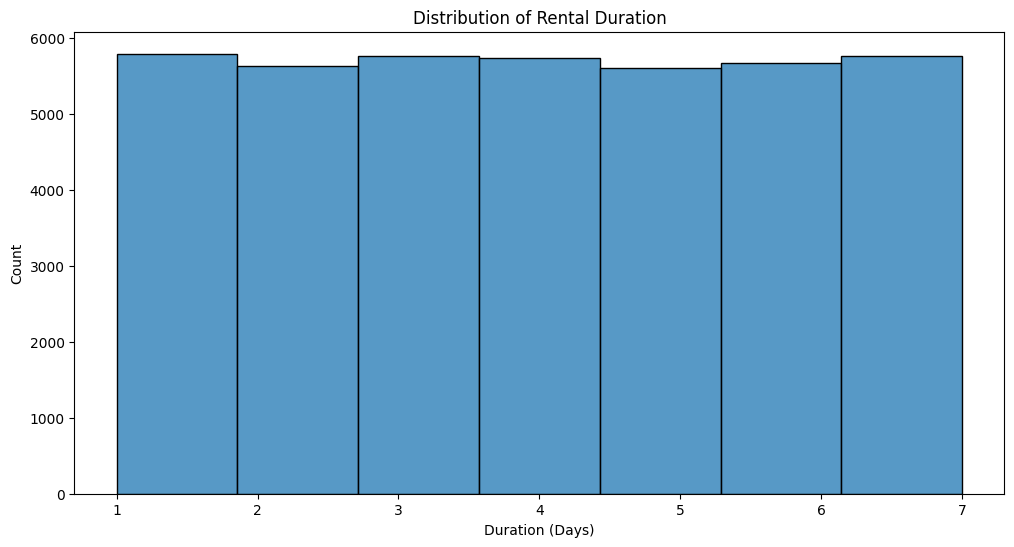

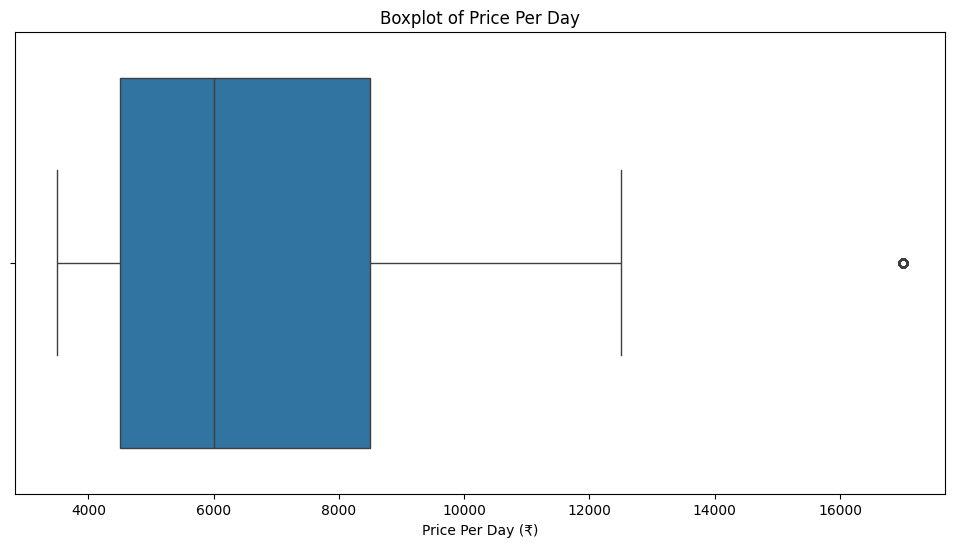

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(12, 6))

# Distribution of Rental Duration
sns.histplot(merged_df['Duration'], bins=7, kde=False)# kde=false because duration is a discrete variable.
plt.title("Distribution of Rental Duration")
plt.xlabel("Duration (Days)")
plt.ylabel("Count")
plt.show()

# Boxplot of Price_Per_Day
plt.figure(figsize=(12, 6))
sns.boxplot(x=merged_df["Price_Per_Day"])
plt.title("Boxplot of Price Per Day")
plt.xlabel("Price Per Day (₹)")
plt.show()


In [9]:
# Convert RentalDate and ReturnDate to datetime format
merged_df['RentalDate'] = pd.to_datetime(merged_df['RentalDate'])
merged_df['ReturnDate'] = pd.to_datetime(merged_df['ReturnDate'])

# # Extract additional time-based features
# merged_df['Rental_Year'] = merged_df['RentalDate'].dt.year
# merged_df['Rental_Month'] = merged_df['RentalDate'].dt.month
# merged_df['Rental_Weekday'] = merged_df['RentalDate'].dt.weekday

# Check if any missing values exist
missing_values = merged_df.isnull().sum()
print("Missing Values:\n", missing_values)

# Display the first few rows after transformation
merged_df.head()

Missing Values:
 RentalID               0
UserID                 0
Pickup_Location        0
RentalDate             0
Duration               0
ReturnDate             0
CarID                  0
TotalAmount            0
Make                   0
Model                  0
CarType                0
Mileage_kmpl           0
Year_Of_Manufacture    0
Price_Per_Day          0
City                   0
Car_Agency             0
Agency_Price           0
LocationID             0
dtype: int64


,RentalID,UserID,Pickup_Location,RentalDate,Duration,ReturnDate,CarID,TotalAmount,Make,Model,CarType,Mileage_kmpl,Year_Of_Manufacture,Price_Per_Day,City,Car_Agency,Agency_Price,LocationID
0,1,0,Visakhapatnam,2019-09-26,3,2019-09-29,9818,28350.0,Ford,Ford Bronco,SUV,10,2024,8500.0,Visakhapatnam,Smart Rides Vizag,950.0,50
1,2,0,Shillong,2019-10-10,3,2019-10-13,6755,25200.0,Hyundai,Hyundai Verna,Sedan,19,2018,5500.0,Shillong,Elite Auto Shillong,2900.0,34
2,3,0,Ranchi,2019-11-14,6,2019-11-20,331,56400.0,Toyota,Toyota Camry,Sedan,19,2017,6500.0,Ranchi,Elite Wheels Ranchi,2900.0,2
3,4,0,Raigarh,2019-12-12,3,2019-12-15,4288,18600.0,Volkswagen,Volkswagen Golf,Hatchback,17,2005,4500.0,Raigarh,Midway Car Rentals Raigarh,1700.0,22
4,5,0,Kolkata,2019-12-26,5,2019-12-31,6287,29500.0,Volkswagen,Volkswagen Polo,Hatchback,18,2019,4000.0,Kolkata,Midway Auto Kolkata,1900.0,32


In [10]:
merged_df=merged_df.drop(columns=['City'],axis=1)


### One-Hot Encoding (`Make`, `CarType`)

In [11]:
# One-Hot Encoding
merged_df = pd.get_dummies(merged_df, columns=['Make', 'CarType'], drop_first=False)

### Label Encoding (`Pickup_Location`, `Model`, `Car_Agency`)

In [12]:
from sklearn.preprocessing import LabelEncoder

label_cols = ['Pickup_Location', 'Model', 'Car_Agency']
encoders = {}  # Dictionary to store LabelEncoders
mappings = {}  # Dictionary to store mappings

for col in label_cols:
    encoders[col] = LabelEncoder()  # Create a new LabelEncoder for each column
    merged_df[col] = encoders[col].fit_transform(merged_df[col])  # Transform column
    mappings[col] = {index: label for index, label in enumerate(encoders[col].classes_)}  # Store mappings


In [13]:
from sklearn.preprocessing import MinMaxScaler
# Identify numerical columns (excluding categorical ones)
numerical_cols = ['Duration', 'TotalAmount', 'Mileage_kmpl', 'Year_Of_Manufacture', 
                  'Price_Per_Day', 'Agency_Price']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMaxScaler to numerical columns
merged_df[numerical_cols] = scaler.fit_transform(merged_df[numerical_cols])

# Display scaled data
print(merged_df.head())

   RentalID  UserID  Pickup_Location RentalDate  Duration ReturnDate  CarID  \
0         1       0               53 2019-09-26  0.333333 2019-09-29   9818   
1         2       0               43 2019-10-10  0.333333 2019-10-13   6755   
2         3       0               42 2019-11-14  0.833333 2019-11-20    331   
3         4       0               40 2019-12-12  0.333333 2019-12-15   4288   
4         5       0               26 2019-12-26  0.666667 2019-12-31   6287   

   TotalAmount  Model  Mileage_kmpl  ...  LocationID  Make_Ford  Make_Honda  \
0     0.168535      0      0.214286  ...          50       True       False   
1     0.146461     22      0.857143  ...          34      False       False   
2     0.365102     24      0.857143  ...           2      False       False   
3     0.100210     33      0.714286  ...          22      False       False   
4     0.176594     35      0.785714  ...          32      False       False   

   Make_Hyundai  Make_Toyota  Make_Volkswagen  Car

In [14]:
num_unique_users = merged_df['UserID'].nunique()
print(f"Number of unique users: {num_unique_users}")

Number of unique users: 1310


In [15]:
num_unique_cars = merged_df['CarID'].nunique()
print(f"Number of unique users: {num_unique_cars}")

Number of unique users: 10559


Yes! You can use different columns for creating the **user-item interaction matrix**, depending on how you define "interaction" between users and cars. Here are some options:  

### Possible Columns for Pivot Table:
| Column Name         | How It Affects Recommendation |
|---------------------|---------------------------------|
| `TotalAmount`      | Prefers expensive car rentals. |
| `Duration`         | Prefers cars rented for longer. |
| `Price_Per_Day`    | Prefers budget-friendly or premium cars. |
| `Mileage_kmpl`     | Prefers fuel-efficient cars. |
| `Car_Agency`       | Prefers cars from specific rental agencies. |

### Example Alternatives:
1️⃣ **Based on Duration (Users who rent for longer might prefer certain cars):**
```python
user_car_matrix = merged_df.pivot_table(index='UserID', columns='CarID', values='Duration', fill_value=0)
```

2️⃣ **Based on Rental Frequency (Users who rented a car multiple times will have higher values):**
```python
user_car_matrix = merged_df.groupby(['UserID', 'CarID']).size().unstack(fill_value=0)
```

3️⃣ **Based on Agency Preference (Users who rent from specific agencies prefer their cars):**
```python
user_car_matrix = merged_df.pivot_table(index='UserID', columns='CarID', values='Car_Agency', aggfunc='count', fill_value=0)
```

### Key Question:
- **Do you want to recommend based on spending behavior (`TotalAmount`), rental duration, or just rental frequency?**  
Let me know which approach you prefer! 🚀

In [16]:
from scipy.sparse import csr_matrix
import pandas as pd

# Create a user-item interaction matrix
car_user_matrix  = merged_df.pivot_table(index='CarID', columns='UserID', values='TotalAmount', fill_value=0)

# Convert to a sparse matrix
sparse_user_car = csr_matrix(car_user_matrix .values)

# Print shape
print(f"Sparse Matrix Shape: {sparse_user_car.shape}")


Sparse Matrix Shape: (10559, 1310)


In [17]:
from sklearn.neighbors import NearestNeighbors

# Initialize the KNN model with cosine similarity
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=-1)

# Fit the model on the sparse matrix
knn_model.fit(sparse_user_car)

print("KNN model trained successfully!")

KNN model trained successfully!


## debugging steps:

In [18]:
# print(merged_df['CarID'].dtype)  # Check CarID type in merged_df
# print(car_user_matrix.index.dtype)  # Check CarID type in car_user_matrix


In [19]:
# print(car_id_to_check in car_user_matrix.index)  # Should return True if it exists


In [20]:
# all_car_ids = merged_df['CarID'].unique()  # Get all CarIDs
# car_user_matrix = car_user_matrix.reindex(all_car_ids, fill_value=0)


## Recommendation function:

In [21]:
def recommend_similar_cars(car_id, car_user_matrix, knn_model, merged_df, top_n=5):
    car_id = int(car_id)  # Ensure CarID is an integer
    
    if car_id not in car_user_matrix.index:
        print(f"⚠️ CarID {car_id} not found in car_user_matrix.")
        return []
    
    # Get the pickup location of the selected car
    pickup_location = merged_df.loc[merged_df['CarID'] == car_id, 'Pickup_Location'].values[0]

    # Get the car vector
    car_vector = car_user_matrix.loc[car_id].values.reshape(1, -1)  

    # Find nearest neighbors
    distances, indices = knn_model.kneighbors(car_vector, n_neighbors=top_n + 10)  # Get more neighbors to filter later

    # Get recommended car IDs (excluding the input car)
    recommended_car_ids = [car_user_matrix.index[i] for i in indices.flatten()[1:]]

    # Filter by pickup location
    filtered_recommended_cars = [
        car for car in recommended_car_ids 
        if merged_df.loc[merged_df['CarID'] == car, 'Pickup_Location'].values[0] == pickup_location
    ]
    
    # Return only top_n cars
    return filtered_recommended_cars[:top_n]


In [22]:
car_id_to_check = merged_df['CarID'].iloc[0]  # Pick a random CarID
recommended_cars = recommend_similar_cars(car_id_to_check, car_user_matrix, knn_model)

print(f"Recommended cars for CarID {car_id_to_check}: {recommended_cars}")

TypeError: recommend_similar_cars() missing 1 required positional argument: 'merged_df'

In [ ]:
recommended_cars = [int(car) for car in recommended_cars]
print(f"Recommended cars for CarID {car_id_to_check}: {recommended_cars}")

Recommended cars for CarID 9818: [5226, 5038, 8166, 6956, 10225]


encoded variables are reversed mapped:

In [ ]:
for col in label_cols:
    merged_df[col] = merged_df[col].map(mappings[col])

one hot encoded variables are reconstructed:

In [ ]:
make_columns = [col for col in merged_df.columns if col.startswith('Make_')]
merged_df['Make'] = merged_df[make_columns].idxmax(axis=1).str.replace('Make_', '')

cartype_columns = [col for col in merged_df.columns if col.startswith('CarType_')]
merged_df['CarType'] = merged_df[cartype_columns].idxmax(axis=1).str.replace('CarType_', '')

In [ ]:
car_details = merged_df[merged_df['CarID'].isin(recommended_cars)][['CarID', 'Make', 'Model', 'CarType','Car_Agency','Pickup_Location']].drop_duplicates()
print(car_details)


       CarID        Make               Model CarType  \
7024   10225       Honda          Honda CR-V     SUV   
9022    6956     Hyundai     Hyundai Elantra   Sedan   
9879    5038     Hyundai    Hyundai Palisade  Luxury   
14712   8166  Volkswagen  Volkswagen Touareg  Luxury   
16892   5226       Honda          Honda HR-V     SUV   

                     Car_Agency     Pickup_Location  
7024          Easy Rides Mysuru              Mysuru  
9022   Prestige Wheels Amritsar            Amritsar  
9879            EasyGo Dehradun            Dehradun  
14712  Luxury Motion Trivandrum  Thiruvananthapuram  
16892    Smart Rentals Srinagar            Srinagar  


In [ ]:
# Get the pickup location of the input CarID
pickup_location = merged_df.loc[merged_df['CarID'] == 5226, 'Pickup_Location'].values[0]

# Extract state from Pickup_Location if available (assuming "City, State" format)
if ',' in pickup_location:
    city, state = pickup_location.split(', ')
else:
    state = pickup_location  # If no state info, use the city as fallback

# Try finding recommended cars in the same city
filtered_recommendations = merged_df[
    (merged_df['CarID'].isin(recommended_cars)) & 
    (merged_df['Pickup_Location'] == pickup_location)
][['CarID', 'Make', 'Model', 'CarType', 'Car_Agency', 'Pickup_Location']].drop_duplicates()

# If no match, find recommendations in the same state
if filtered_recommendations.empty:
    print("No exact city match found. Searching within the same state...")
    filtered_recommendations = merged_df[
        (merged_df['CarID'].isin(recommended_cars)) & 
        (merged_df['Pickup_Location'].str.contains(state, na=False))
    ][['CarID', 'Make', 'Model', 'CarType', 'Car_Agency', 'Pickup_Location']].drop_duplicates()

# If still empty, recommend from the most booked locations
if filtered_recommendations.empty:
    print("No state match found. Recommending from top booked locations...")
    top_locations = merged_df['Pickup_Location'].value_counts().index[:5].tolist()

    filtered_recommendations = merged_df[
        (merged_df['CarID'].isin(recommended_cars)) & 
        (merged_df['Pickup_Location'].isin(top_locations))
    ][['CarID', 'Make', 'Model', 'CarType', 'Car_Agency', 'Pickup_Location']].drop_duplicates()

print(filtered_recommendations)


       CarID   Make       Model CarType              Car_Agency  \
16892   5226  Honda  Honda HR-V     SUV  Smart Rentals Srinagar   

      Pickup_Location  
16892        Srinagar  
